In [1]:
import argparse
import os
import pathlib
import string
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()
image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot/NF1_organoid_data")).resolve(),
    root_dir,
)

In [2]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [3]:
def plot_plate_overview(
    plate: str,
    image_sub_string_to_search: str,
    available_wells: dict,
    layout: int = "96",
    image_color_map: str = "nipy_spectral",
) -> plt.Figure:
    """
    Generate a plate-view of images from each well

    Parameters
    ----------
    plate : str
        plate identifier
    image_sub_string_to_search : str
        Substring to search for in image filenames within each well directory
    available_wells : dict
        Dictionary mapping well positions to their corresponding directories
        Dictionary is in the following format:
            {"well_position": pathlib.Path("path/to/well_directory"), ...}
    layout : int, optional
        Plate layout, by default "96"
    """
    if layout == "96":
        rows = list(
            string.ascii_uppercase[:8]
        )  # ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        cols = list(range(1, 13))  # [1, 2, 3, ..., 12]

    # Create a 8x12 grid for 96-well plate
    fig, axes = plt.subplots(8, 12, figsize=(20, 16))
    fig.suptitle(
        f"{layout}-Well Plate Overview - Plate: {plate}", fontsize=16, fontweight="bold"
    )
    # show in a grid one image per plate well
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            ax = axes[i, j]
            well_position = f"{row}{col:02d}"  # Add leading zero with :02d formatting
            well_position_no_zero = f"{row}{col}"  # Keep original for lookup

            # Check if this well has data (check both formats)
            if (
                well_position_no_zero in available_wells
                or well_position in available_wells
            ):
                well_dir = available_wells.get(
                    well_position_no_zero
                ) or available_wells.get(well_position)
                # Get the first image file from this well
                image_files = sorted(
                    list(well_dir.glob(f"*{image_sub_string_to_search}*"))
                )
                nuclei_mask = read_zstack_image(image_files[0])
                mid_z = nuclei_mask.shape[0] // 2
                nuclei_mask = nuclei_mask[mid_z]
                ax.imshow(nuclei_mask, cmap=image_color_map)
                # add platemap outline
                if "A" in well_position:
                    ax.set_title(f"{well_position[0]}")
                # use if as both row and column could be true for the statement
                if "01" in well_position:
                    ax.set_title(f"{well_position[1:]}", fontsize=10)
            else:
                if "01" in well_position:
                    ax.set_title(f"{well_position[0]}")
                # use if as both row and column could be true for the statement
                if "A" in well_position:
                    if well_position[1:].startswith("0"):
                        ax.set_title(f"{well_position[2]}")
                    else:
                        ax.set_title(f"{well_position[1:]}", fontsize=10)
                ax.axis("off")
            ax.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

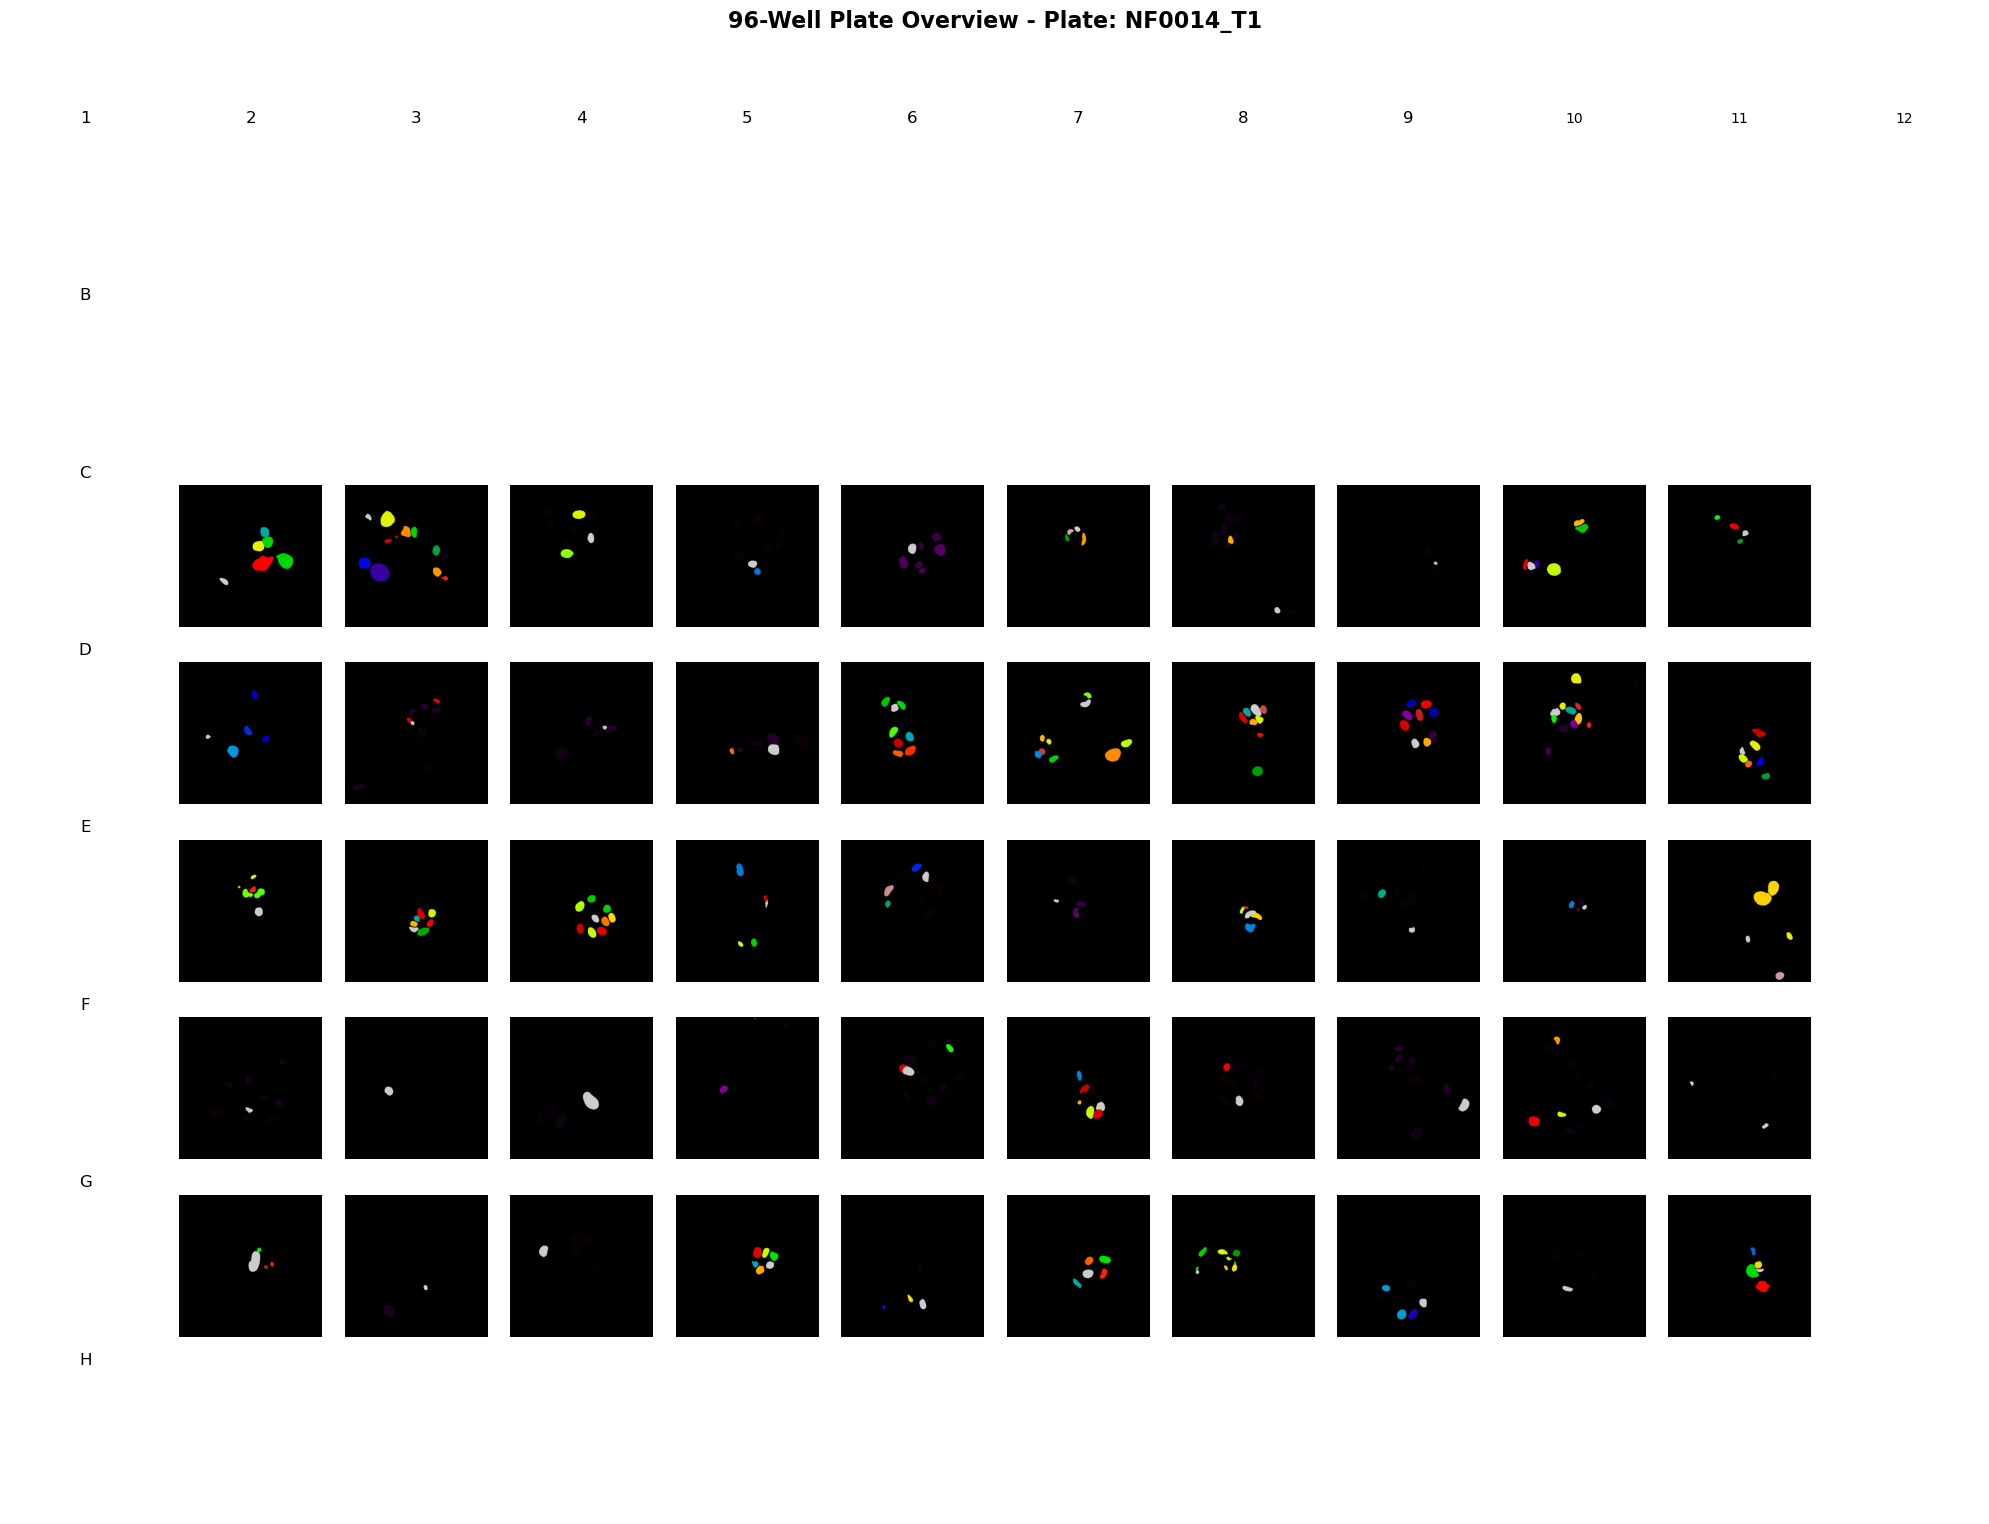

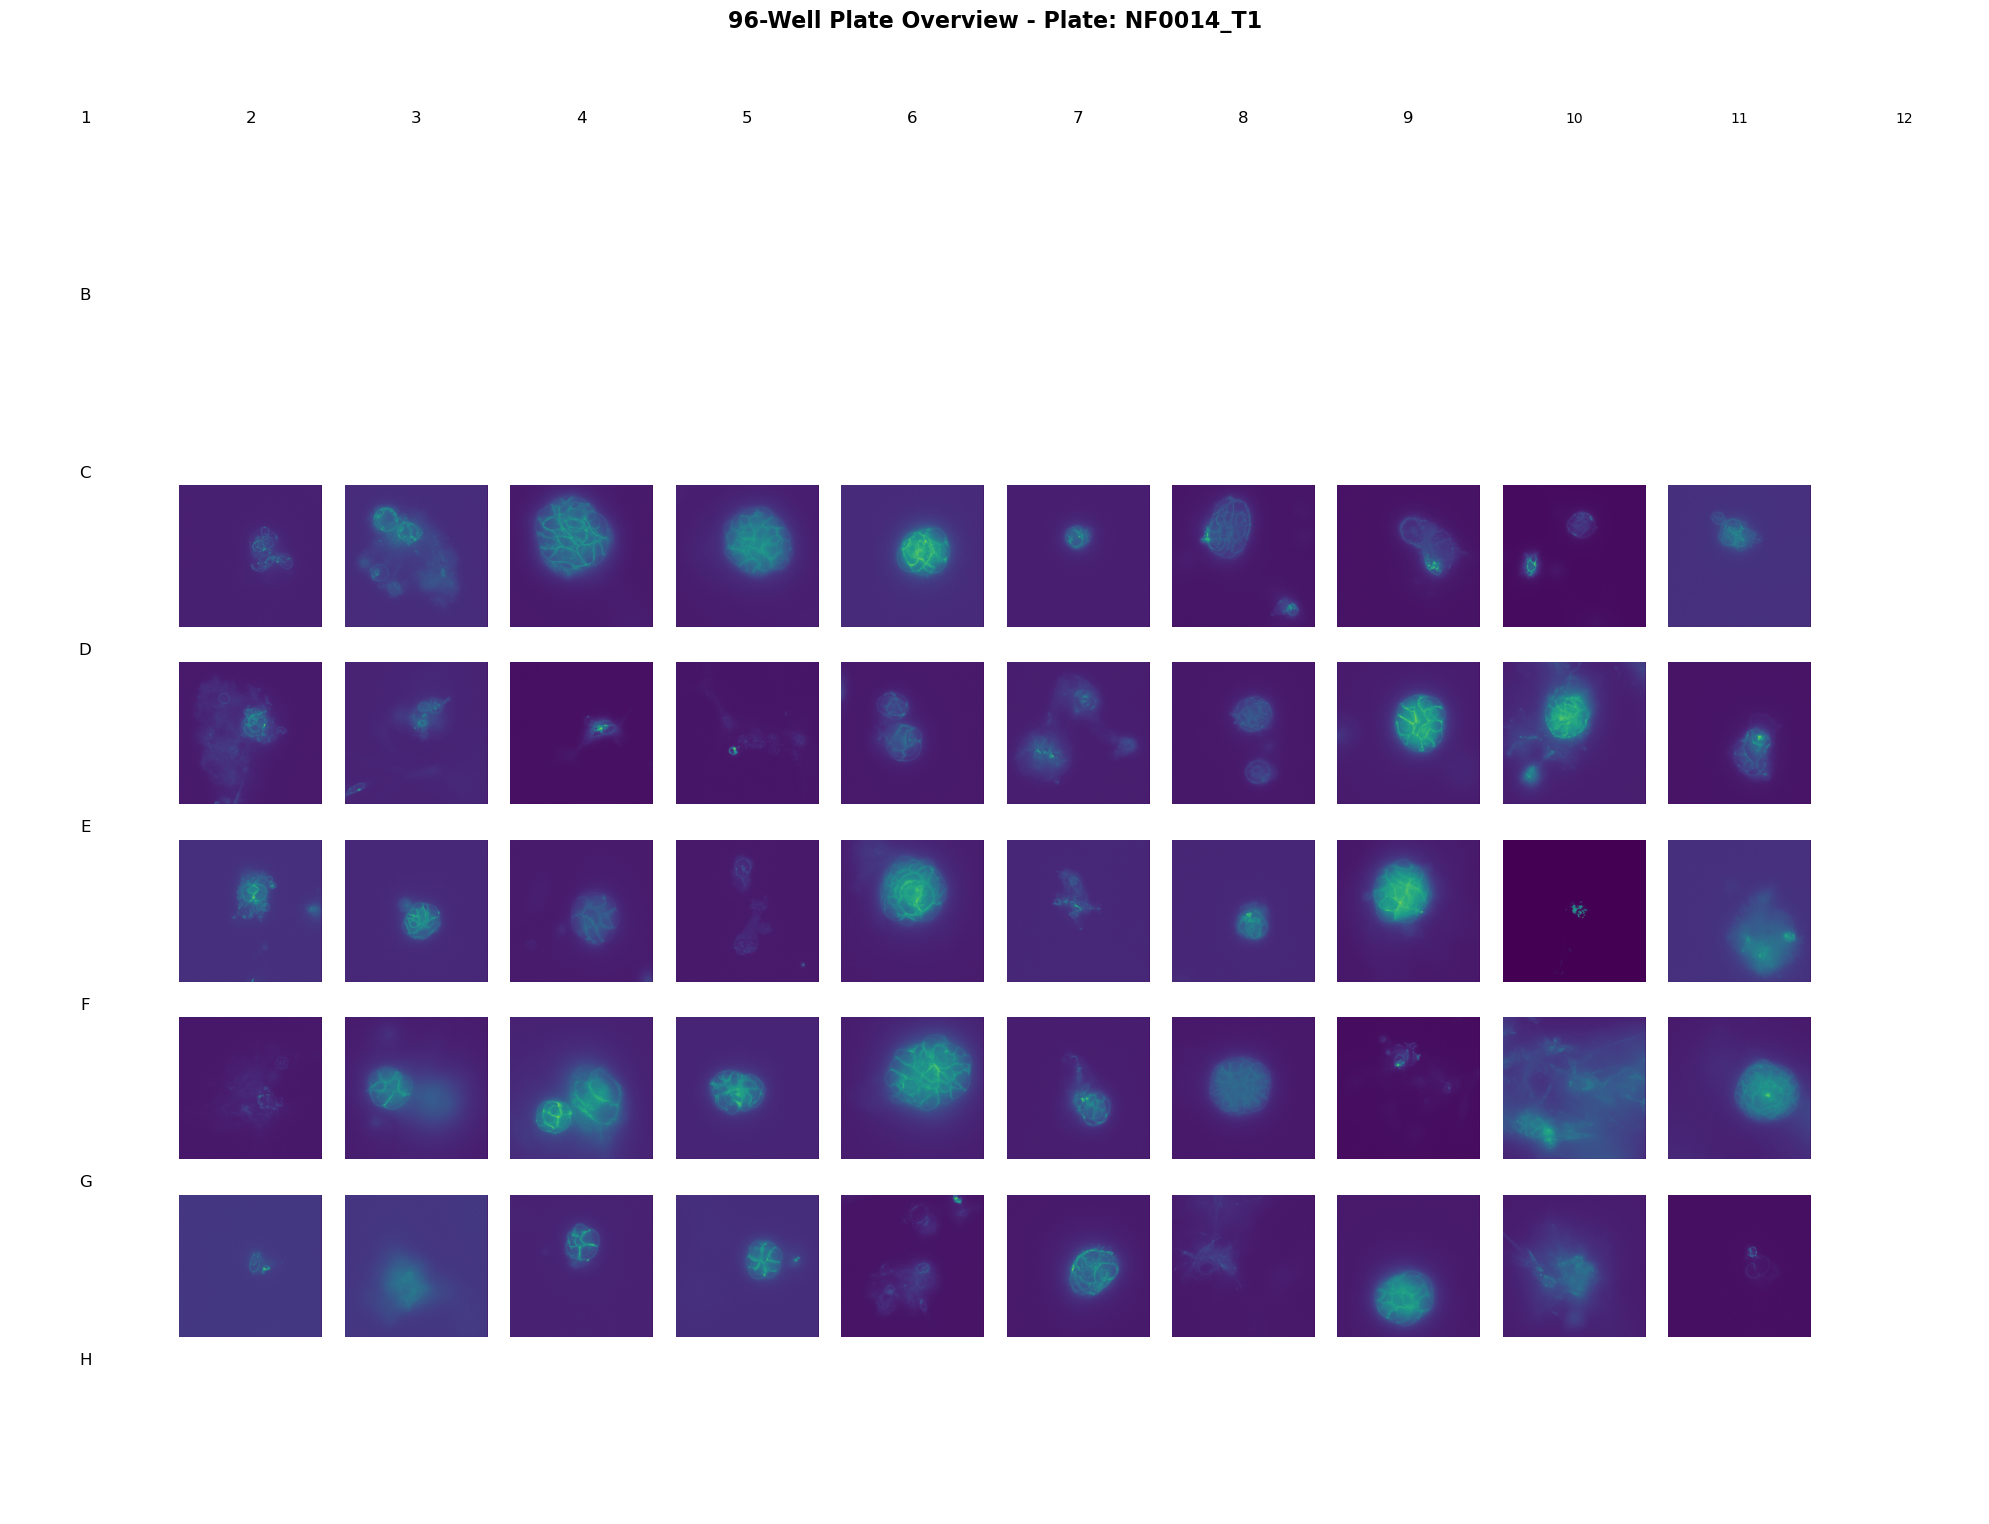

In [4]:
well_fovs = mask_path.glob("*")
mask_available_wells = {}
for well_fov_path in well_fovs:
    if not well_fov_path.is_dir():
        continue
    well_fov_name = well_fov_path.stem.split("-")[0]
    mask_available_wells[well_fov_name] = well_fov_path

well_fovs = input_dir.glob("*")
image_available_wells = {}
for well_fov_path in well_fovs:
    if not well_fov_path.is_dir():
        continue
    well_fov_name = well_fov_path.stem.split("-")[0]
    image_available_wells[well_fov_name] = well_fov_path

fig = plot_plate_overview(
    plate=patient,
    image_sub_string_to_search="nuclei",
    available_wells=mask_available_wells,
    layout="96",
    image_color_map="nipy_spectral",
)
plt.show()
fig = plot_plate_overview(
    plate=patient,
    image_sub_string_to_search="555",
    available_wells=image_available_wells,
    layout="96",
    image_color_map="viridis",
)
plt.show()